#Load data

In [1]:
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset
import glob
!pip install natsort
import natsort
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#images_path = '/kaggle/input/gland-data/Gland_dataset/*'
#!ls drive/'My Drive'
!ls drive/'My Drive/Cellari_project/Gland_dataset' &> /dev/null

images_path = 'drive/My Drive/Cellari_project/Gland_dataset/*'


In [4]:
images = []
masks = []

# image preperation
train_images = glob.glob(images_path)
sorted_train_images = natsort.natsorted(train_images, reverse=False)


In [5]:
for img in train_images:
    name_img = img.split("/")[-1].split(".")[0]
    imagg = name_img.split("_")[-1]
    if imagg == "anno":
        masks.append(img)
    else:
        images.append(img)

print(len(images))
print(len(masks))
#print(imagg)


145
145


In [6]:
train_orig_images = []
train_masks = []

test_orig_images = []
test_masks = []

In [7]:
for img in images:
    name_img = img.split("/")[-1].split(".")[0]
    imagg = name_img.split("_")[0]
    if imagg == "testA" or imagg == "testB":
        test_orig_images.append(img)
    else:
        train_orig_images.append(img)

for mask in masks:
    mask_img = mask.split("/")[-1].split(".")[0]
    imagg = mask_img.split("_")[0]
    if imagg == "testA" or imagg == "testB":
        test_masks.append(mask)
    else:
        train_masks.append(mask)


In [8]:
print(len(train_orig_images), len(train_masks))
print(len(test_orig_images), len(test_masks))

85 85
60 60


In [9]:
sorted_train_images = natsort.natsorted(train_orig_images, reverse=False)
sorted_train_masks = natsort.natsorted(train_masks, reverse=False)

sorted_test_images = natsort.natsorted(test_orig_images, reverse=False)
sorted_test_masks = natsort.natsorted(test_masks, reverse=False)

In [10]:
#mean = (0.485, 0.456, 0.406)
#std = (0.229, 0.224, 0.225)
#mean = np.array([0.5, 0.5, 0.5])
#std = np.array([0.5, 0.5, 0.5])
mean = np.array([0.7874, 0.5112, 0.7851])
std = np.array([0.1522, 0.2089, 0.111])

transformations = transforms.Compose([transforms.Resize((512,512)) , transforms.ToTensor() , transforms.Normalize(mean, std)])



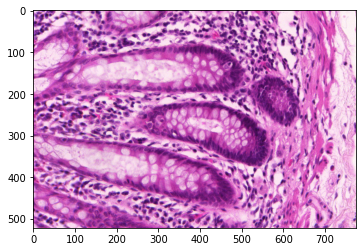

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
img = Image.open(sorted_train_images[61]).convert("RGB")
#img = img.resize((512,512))
plt.imshow(img)

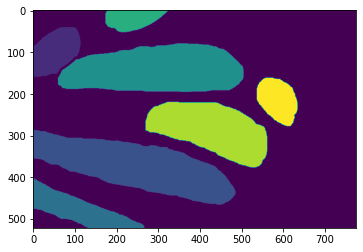

In [12]:
#check mask
mask = Image.open(sorted_train_masks[61])
#mask = mask.resize((512,512))

plt.imshow(mask)

In [13]:
print(type(img))
print(type(mask))
print(img.size)

<class 'PIL.Image.Image'>
<class 'PIL.BmpImagePlugin.BmpImageFile'>
(775, 522)


In [14]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as TF
import random


class CellarDataset(object):
    def __init__(self, images, masks, transforms,train):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = images
        self.masks = masks
        self.transforms = transforms
        self.train = train

    def __getitem__(self, idx):
        #print("current idx =",idx)
        #print("len self.imgs =",len(self.imgs))
        img = Image.open(self.imgs[idx]).convert("RGB")
        #img = img.resize((512,512))
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(self.masks[idx])
        #mask = mask.resize((512,512))
        # Random horizontal flipping
        
        if(self.train):
            """
            #pad img if too small
            row,col = img.size
            if row<512:

                amount_of_padding =int((512-row)/2)
                if amount_of_padding %2 ==0:
                    padding = TF.Pad((amount_of_padding,0))
                else:
                    padding = TF.Pad((amount_of_padding+1,0))

                img = padding(img)
                mask = padding(mask)
            if col<512:
                amount_of_padding =int((512-col)/2)

                if amount_of_padding %2 ==0:
                    padding = TF.Pad((0,amount_of_padding))
                else:
                    padding = TF.Pad((0,amount_of_padding+1))
                img = padding(img)
                mask = padding(mask)

            # Random crop
            i, j, h, w = TF.RandomCrop.get_params(img, output_size=(512, 512))
            img = TF.functional.crop(img, i, j, h, w)
            mask = TF.functional.crop(mask, i, j, h, w)
            """
            
            if random.random() > 0.5:
                img = TF.functional.hflip(img)
                mask = TF.functional.hflip(mask)

            # Random vertical flipping
            if random.random() > 0.5:
                img = TF.functional.vflip(img)
                mask = TF.functional.vflip(mask)
            
            #if random.random()>0.5:
                #my_rotation = TF.RandomRotation(20, expand = True,resample=Image.BILINEAR)
                #img = my_rotation(img)
                #mask = my_rotation(mask)
                
            #if random.random()>0.5:
                #my_color = TF.ColorJitter(hue=.05, saturation=.05)
                #img = my_color(img)
    
            #if random.random()>0.5:
                #my_blur = TF.GaussianBlur(5, sigma=(0.1, 2.0))
                #img = my_blur(img)
    
        mask = np.array(mask)
        #convert to black and white image

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmax-xmin > 2 and ymax-ymin > 2 :
              boxes.append([xmin, ymin, xmax, ymax])
            else :
              obj_ids = np.delete(obj_ids,i)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        #target["area"] = 1 
        #target["iscrowd"] = False 
        
        my_to_tensor = TF.ToTensor()
        #target = my_to_tensor(target)
        img = my_to_tensor(img)
        #if self.transforms is not None:
        #   img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

#Modifying the model from a pretrained RCNN

In [15]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    #hidden_layer = 512
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [16]:
%%bash

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [17]:
!pip install pycocotools
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
        #transforms.append(torchvision.transforms.RandomVerticalFlip(0.5))
    return T.Compose(transforms)

In [18]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, loss_train,  loss_val, data_loader_test):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()
        loss_train.append(loss_value)

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        #my_loss_train.append(metric_logger)

    for images, targets in metric_logger.log_every(data_loader_test, 60, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()
        loss_val.append(loss_value)
    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    #print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()
    
    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [19]:
# use our dataset and defined transformations
dataset = CellarDataset(sorted_train_images,sorted_train_masks,get_transform(train=True),True)
dataset_test = CellarDataset(sorted_test_images,sorted_test_masks,get_transform(train=False),False)

# split the dataset in train and test set
torch.manual_seed(1)
indices_train = torch.randperm(len(dataset)).tolist()
indices_test = torch.randperm(len(dataset_test)).tolist()
#dataset = torch.utils.data.Subset(dataset, indices[:-50])
#dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
#dataset = torch.utils.data.Subset(dataset, indices_train[:])
#dataset_test = torch.utils.data.Subset(dataset_test, indices_test[:])
dataset = torch.utils.data.Subset(dataset, indices_train[:])
dataset_test = torch.utils.data.Subset(dataset_test, indices_test[:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=5, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)


print(indices_train)
print(len(dataset))

[70, 60, 72, 5, 83, 78, 33, 48, 8, 9, 6, 44, 3, 84, 26, 55, 37, 74, 14, 71, 25, 58, 75, 39, 68, 61, 18, 57, 66, 4, 21, 69, 32, 11, 29, 30, 40, 67, 22, 43, 15, 82, 51, 54, 63, 50, 0, 46, 81, 53, 79, 2, 56, 77, 59, 24, 76, 23, 20, 35, 7, 36, 65, 62, 73, 12, 28, 42, 10, 49, 17, 27, 13, 38, 80, 34, 19, 47, 64, 52, 1, 31, 16, 41, 45]
85


In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
                            
#optimizer = torch.optim.Adam(params, lr=0.005, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=20,
                                               gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 60                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
loss_val = []
loss_train = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, 60,loss_train, loss_val,data_loader_test)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:

#plot training loss
batches = []
selected_validation = []
for i in range(0,len(loss_train)):
    batches.append(i+1)
plt.plot(batches,loss_train,label = "Training loss")

plt.xlabel('batch number')
plt.ylabel('loss')
plt.title('Training loss')
plt.legend()
plt.show()

batches = []
selected_validation = []
batches_val = []
for i in range(0,len(loss_val)):
    batches.append(i+1)

selected_validation = []
for i in range(0,len(loss_val),60):
    selected_validation.append((np.sum(np.array(loss_val[i:i+59]))/60))

selected_training = []
for i in range(0,len(loss_train),17):
    selected_training.append((np.sum(np.array(loss_train[i:i+16]))/17))
#for i in range(0,len(loss_train),11):
    #selected_training.append((np.sum(np.array(loss_train[i:i+10]))/11))


for i in range(0,len(selected_validation)):
    batches_val.append(i+1)

plt.plot(batches_val,selected_validation,label = "Validation loss")
plt.plot(batches_val,selected_training,label = "training loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(' Validation loss')
plt.legend()
plt.show()

In [ ]:
# pick one image from the test set
img, features = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
masks = features['masks']
mask_np = masks.mul(255).permute(1, 2, 0).byte().cpu().numpy()
true_mask = None
for i in range(0,mask_np.shape[2]):
  mask = mask_np[:,:,i]
  if i != 0:
    true_mask = np.bitwise_or(true_mask,mask)
  else:
    true_mask = mask

plt.imshow(true_mask,cmap='gray')
plt.show()

In [ ]:
img_np = prediction[0]['masks'][:, 0].mul(255).permute(1, 2, 0).byte().cpu().numpy()
predicted_cells = None
for i in range(0,img_np.shape[2]):
  img = img_np[:,:,i]
  ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
  if i != 0:
    predicted_cells = np.bitwise_or(predicted_cells,img)
  else:
    predicted_cells = mask

plt.imshow(predicted_cells,cmap='gray')
#plt.show()

In [ ]:
#predicted_cells[0:30,0:30]

In [ ]:
print(dataset_test)

In [ ]:
!git clone https://github.com/scikit-image/scikit-image.git
!cd scikit-image
!pip install -e

In [ ]:
from skimage.measure import label
from skimage import metrics
import skimage

import numpy as np
from scipy.spatial import cKDTree

def hausdorff_distance(image0, image1):
    a_points = np.transpose(np.nonzero(image0))
    b_points = np.transpose(np.nonzero(image1))
    if len(a_points) == 0:
        return 0 if len(b_points) == 0 else np.inf
    elif len(b_points) == 0:
        return np.inf

    return max(max(cKDTree(a_points).query(b_points, k=1)[0]),
               max(cKDTree(b_points).query(a_points, k=1)[0]))

In [ ]:
import numpy as np
from skimage.measure import label
#from skimage.metrics import hausdorff_distance

class BinaryImageMetrics():
    def __init__(self, y_true, y_pred):
        #TODO: Add documentation
        #TODO: implement Adjusted Rand Index and https://web.stanford.edu/class/cs273/scribing/2004/class8/scribe8.pdf
        
        # Numpy have the bug : ValueError: cannot set WRITEABLE flag to True of this array
        # That is why we copy the array

        # We force the predictions to be binary

        y_true = np.copy(y_true)
        y_pred = np.copy(y_pred)
        y_true[y_true>0]=1
        y_pred[y_pred>0] = 1
        self.y_true= y_true
        self.y_pred = y_pred
        self.y_true_label = label(self.y_true)
        self.y_pred_label = label(self.y_pred)

    def get_count(self):
        count_y_true = np.max(self.y_true_label)
        count_y_pred = np.max(self.y_pred_label)
        if count_y_pred == 0 or count_y_true == 0:
            return 0.0
        else:
            return min(count_y_true/count_y_pred, count_y_pred/count_y_true)

    def get_f1(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = 2*tp / (2*tp +fp + fn)
        return f1
        
    def get_iou(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
            
        if y_true.max() == 0 and y_pred.max()==0:
            return 0.0 
            
        tp, fp, _, fn = self.confusion_matrix(y_true, y_pred)
        f1 = tp / (tp +fp + fn)
        return f1

    def get_hausdroff_dist(self, y_true=None, y_pred=None):
        if y_true is None:
            y_true = self.y_true
        if y_pred is None:
            y_pred = self.y_pred
        
        if y_true.max() == 0 or y_pred.max() == 0:
            haus_dist = np.sqrt(y_true.shape[0]*y_true.shape[1])
        else:
            haus_dist = hausdorff_distance(y_true, y_pred)
        return haus_dist

    def get_iou_obj(self):
        iou_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            iou = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_iou(y_true=gi, y_pred=si)
            iou_obj += iou

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            iou = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_iou(y_true=si, y_pred=gi)
            iou_obj += iou

        iou_obj /= 2

        return iou_obj


    def get_f1_obj(self):
        f1_obj = 0
        total_y_pred = max(np.bincount(self.y_pred.flatten(),minlength=2)[1],1)
        total_y_true = max(np.bincount(self.y_true.flatten(), minlength=2)[1],1)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=False)
            f1 = (np.bincount(gi.flatten(), minlength=2)[1]/total_y_true)*self.get_f1(y_true=gi, y_pred=si)
            f1_obj += f1

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=False, y_true_p_switch=True)
            f1 = (np.bincount(si.flatten(), minlength=2)[1]/total_y_pred)*self.get_f1(y_true=si, y_pred=gi)
            f1_obj += f1

        f1_obj /= 2

        return f1_obj


    def get_hausdorff_obj_distance(self):
        haus_dist_obj = 0
        total_y_pred = np.bincount(self.y_pred.flatten(), minlength=2)[1]
        total_y_true = np.bincount(self.y_true.flatten(), minlength=2)[1]
        
        if total_y_true == 0 or total_y_pred == 0:
            # Note this conversion is different from
            # https://warwick.ac.uk/fac/sci/dcs/research/tia/glascontest/evaluation/
            # But the Hausdorff distance is not defined for non-overlapping objects.
            # Note that the distance of sqrt(h^2+w^2) is an arbary choice.
            # 0.0 would skew the distance to much to the positive side, and
            # infinite is misleading. 
            # In case both objects are empty, we return the max dist of y_true
            return np.sqrt(self.y_true.shape[0]**2+self.y_true.shape[1]**2)

        for idx in range(1, self.y_true_label.max()+1):
            gi, si = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=False)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((gi.shape[0]*gi.shape[1])/total_y_true)*np.sqrt(gi.shape[0]**2+gi.shape[1]**2)
            else:
                haus_dist = (np.bincount(gi.flatten())[1]/total_y_true)*self.get_hausdroff_dist(y_true=gi, y_pred=si)
            haus_dist_obj += haus_dist

        for idx in range(1, self.y_pred_label.max()+1):
            si, gi = self._get_overlap(idx, return_rectangle=True, y_true_p_switch=True)
            if gi.max() == 0 or si.max() == 0:
                haus_dist = ((si.shape[0]*si.shape[1])/total_y_pred)*np.sqrt(si.shape[0]**2+si.shape[1]**2)
            else:
                haus_dist = (np.bincount(si.flatten())[1]/total_y_pred)*self.get_hausdroff_dist(y_true=si, y_pred=gi)
            haus_dist_obj += haus_dist

        haus_dist_obj /= 2
        return haus_dist_obj

    def confusion_matrix(self, y_true, y_pred):
        y_true= y_true.flatten()
        y_pred = y_pred.flatten()*2
        cm = y_true+y_pred
        cm = np.bincount(cm, minlength=4)
        tn, fp, fn, tp = cm
        return tp, fp, tn, fn
    
    def _get_overlap(self, idx, return_rectangle=False, y_true_p_switch=False):
        if y_true_p_switch:
            y_pred = self.y_true_label
            y_true = self.y_pred_label
        else:
            y_true = self.y_true_label
            y_pred = self.y_pred_label

        roi_y_true = np.argwhere(y_true == idx)
        roi_y_pred = y_pred[roi_y_true[:,0],roi_y_true[:,1]]

        # Finds max overlap, excluding background
        matching_idx = np.bincount(roi_y_pred)
        if len(matching_idx)<=1:
            matching_idx = -1
        else:
            matching_idx = matching_idx[1:].argmax()+1
        if return_rectangle:
            bbox, _, _ = self._bounding_box(roi_y_true, at_origon=False)
            roi_y_true = y_true[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_pred = y_pred[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]
            roi_y_true =(roi_y_true==idx)*1

        else:
            roi_y_true = np.ones((len(roi_y_true)),dtype=int)
        roi_y_pred = (roi_y_pred==matching_idx)*1
        
        return roi_y_true, roi_y_pred
        
    def _bounding_box(self, points, at_origon=False):
        bbox = [min(points[:,0]), min(points[:,1]), max(points[:,0]), max(points[:,1])]
        min_x = bbox[0]
        min_y = bbox[1]
        if at_origon:
            bbox = [bbox[0] - min_x,
                    bbox[1] - min_y,
                    bbox[2] - min_x,
                    bbox[3] - min_y]
        return bbox, min_x, min_y

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
my_img = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
plt.imshow(my_img )

In [ ]:
#my_img = np.array(my_img)
#my_img[0:30,270:300]

In [ ]:
"""
img_np = prediction[0]['masks'][:, 0].mul(255).permute(1, 2, 0).byte().cpu().numpy()
print(img_np.shape)
predicted_cells = None
for i in range(0,img_np.shape[2]):
  img = img_np[:,:,i]
  if i != 0:
    predicted_cells = np.bitwise_or(predicted_cells,img)
  else:
    predicted_cells = mask

plt.imshow(predicted_cells,cmap='gray')
plt.show()
"""

In [ ]:
#Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [ ]:
  # display images 
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy()) 

In [ ]:
  # display images
Image.fromarray(prediction[0]['masks'][2, 0].mul(255).byte().cpu().numpy()) 

In [ ]:
img2 = dataset_test.dataset.masks[15]
img2 = Image.open(img2)
plt.imshow(img2)


In [ ]:
print(len(prediction[0]['masks']))
print(len(prediction[0]['scores']))
print(prediction[0]['scores'])

In [ ]:
count = []
f1 = []
f1_obj = []
iou = []
iou_obj = []
hausdorff_obj_distance = []

for j in range(0,len(dataset_test)):
  if j%10 == 0:
    print("Done with prediction number",j)
  # pick one image from the test set
  orig_img, features = dataset_test[j]
  # put the model in evaluation mode
  model.eval()
  with torch.no_grad():
      prediction = model([orig_img.to(device)])
  # create the true mask of the image

  
  masks = features['masks']
  mask_np = masks.mul(255).permute(1, 2, 0).byte().cpu().numpy()
  #true_mask = np.zeros((mask_np.shape[0],mask_np.shape[1]))
  for i in range(0,mask_np.shape[2]):
    mask = mask_np[:,:,i]
    if i == 0:
      true_mask = mask 
    else:
      true_mask = np.bitwise_or(true_mask,mask)  

  #create the predicted mask of the image
  img_np = prediction[0]['masks'][:, 0].mul(255).permute(1, 2, 0).byte().cpu().numpy()
  scores = prediction[0]['scores']
  
  #predicted_cells = np.zeros((img_np.shape[0],img_np.shape[1]))
  for k in range(0,img_np.shape[2]):
    if scores[k] > 0.5:
      img = img_np[:,:,k]
      ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
      if k == 0:
        predicted_cells = img
        
      else:
        predicted_cells = np.bitwise_or(predicted_cells,img)
  # score the pridiction
  metrics = BinaryImageMetrics(true_mask, predicted_cells)
  count.append(metrics.get_count())
  f1.append(metrics.get_f1())
  f1_obj.append(metrics.get_f1_obj())
  iou.append(metrics.get_iou())
  iou_obj.append( metrics.get_iou_obj())
  hausdorff_obj_distance.append(metrics.get_hausdorff_obj_distance())

#results = [count_avg,f1_avg,f1_obj_avg,iou_avg,iou_obj_avg,hausdorff_obj_distance_avg]
#print(results)



In [ ]:
# Importing library 
import csv 
  
# data to be written row-wise in csv fil 
data = ( loss_train, loss_val,selected_training,selected_validation,indices_test,count,f1,f1_obj,iou, iou_obj ,hausdorff_obj_distance )

# opening the csv file in 'w+' mode 
file = open('aug_60.csv', 'w+', newline ='') 
  
# writing the data into the file 
with file:     
    write = csv.writer(file) 
    write.writerows(data) 

In [ ]:
# pick one image from the test set
orig_img, features = dataset_test[59]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([orig_img.to(device)])
# create the true mask of the image
#create the predicted mask of the image
img_np = prediction[0]['masks'][:, 0].permute(1, 2, 0).mul(255).byte().cpu().numpy()
scores = prediction[0]['scores']
for k in range(0,img_np.shape[2]):
    if scores[k] > 0.5:
      img = img_np[:,:,k]
      ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
      if k != 0:
        predicted_cells = np.bitwise_or(predicted_cells,img)
      else:
        predicted_cells = img
#my_img = Image.open(sorted_test_images[34]).convert("RGB")
my_img = Image.open(sorted_test_images[34]).convert("RGB")
my_img = np.array(my_img)
my_true_mask = Image.open(sorted_test_masks[34])
my_true_mask = np.array(my_true_mask)

for i in range(0,len(my_true_mask[:,0])):
    for j in range(0,len(my_true_mask[0,:])):
        value = my_true_mask[i,j]
        if value >0:
            my_true_mask[i,j] = 255
#ret,my_true_mask = cv2.threshold(my_true_mask,1,255,cv2.THRESH_BINARY)
    
cv2.imwrite("my_img.png",my_img)
cv2.imwrite("my_true_mask.png",my_true_mask)
cv2.imwrite("my_prediction.png",predicted_cells)

# Find external contours
contours, hierarchy = cv2.findContours(predicted_cells,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contours = np.array(contours)
# Iterate over all contours

mask_contours, hierarchy = cv2.findContours(my_true_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
my_true_mask = cv2.cvtColor(my_true_mask,cv2.COLOR_GRAY2BGR)
for i,c in enumerate(mask_contours):
    
    cv2.fillPoly(my_true_mask, mask_contours, (0,0,255))
for i,c in enumerate(contours):
    
    cv2.fillPoly(my_true_mask, contours, (255,255,0))
    
plt.imshow(my_true_mask)
cv2.imwrite("new_prediction_mask.png",my_true_mask)


In [ ]:
import colorsys
# visualize
# pick one image from the test set
orig_img, features = dataset_test[25]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([orig_img.to(device)])

# create the true mask of the image
masks = features['masks']
mask_np = masks.permute(1, 2, 0).mul(255).byte().cpu().numpy()
for i in range(0,mask_np.shape[2]):
    mask = mask_np[:,:,i]
    if i != 0:
        true_mask = np.bitwise_or(true_mask,mask)
    else:
        true_mask = mask

#create the predicted mask of the image
img_np = prediction[0]['masks'][:, 0].permute(1, 2, 0).mul(255).byte().cpu().numpy()
scores = prediction[0]['scores']
for k in range(0,img_np.shape[2]):
    if scores[k] > 0.5:
      img = img_np[:,:,k]
      if k != 0:
        predicted_cells = np.bitwise_or(predicted_cells,img)
      else:
        predicted_cells = img
plt.imshow(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
mean = np.array([0.7874, 0.5112, 0.7851])
std = np.array([0.2089, 0.2089, 0.111])
inv_normalize = TF.Normalize(mean=[-0.7874*0.1522, -0.5112*0.2089, -0.7851*0.111],std=[1/0.2089, 1/0.2089, 1/0.111])
orig_img = inv_normalize(orig_img)

orig_img = np.array(orig_img)
true_mask = np.array(true_mask)
predicted_cells = np.array(predicted_cells)

new_img =orig_img.copy()
new_true_mask =true_mask.copy()
new_predicted_cells = predicted_cells.copy

import numpy as np
import cv2


#pick one image from the test set
orig_img, features = dataset_test[25]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([orig_img.to(device)])

